## Coding Discussion 05 - Week 11
### 8 November 2020
#### Kryslette Bunyi

# Instructions

**Can we predict whether someone will vote or not?**

In the discussion folder, you'll find the `turnout.csv` data, which was drawn from the 2012 National Election Survey. The data records the age, education level (of total years in school), income, race (caucasian or not), and past voting record (i.e. whether or not the respondent voted in the 2012 Presidential election). The sample is composed of 2000 individual respondents. 

Please break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%). 

Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier must be built from scratch. Do not use a third party ML or statistical package. 

Run your algorithm and see how it predicts on the test data. Use the `sklearn.metrics` library to calculate the predictive accuracy and the area underneath the ROC curve. 

Does your model perform better than chance (i.e. coin flip)?

When completing this answer, be sure to: 

- comment on all your code
- provide a narrative for what you're doing
- summarize your results and findings

In [1]:
# Load needed packages
import pandas as pd
import numpy as np
import pprint as pp #for printing
import scipy.stats as st #for Normal PDF
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [2]:
# Read in data
turnout = pd.read_csv("turnout.csv")

# Preview data
turnout.head()

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1


In [3]:
# Set seed
np.random.seed(123)

# Split into training and test datasets
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

# Verify the sizes of the datasets
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

Training Data: 1600 
Test Data: 400


### Calculate Class Probabilities: $Pr(class)$

In [4]:
# Store training sample size
N = train.shape[0]

# Subset the data by class
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vote_1 = vote1.shape[0]/N
pr_vote_0 = vote0.shape[0]/N

# Print the probabilities
print(
f"""
Training Dataset:
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Training Dataset:
Pr(vote = 1): 0.744375
Pr(vote = 0): 0.255625



In [5]:
# Store class probabilities into dictionary
class_probs = {0:pr_vote_0,1:pr_vote_1}
class_probs

{0: 0.255625, 1: 0.744375}

### Calculate Conditional Probabilities $Pr(data | class)$

#### Binary Predictors

In [6]:
# For predictor "white"
white1_vote1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
white0_vote1 = vote1.query("white == 0").shape[0]/vote1.shape[0]
white1_vote0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
white0_vote0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

print(
f"""
Pr(white = 1 |vote = 1): {white1_vote1}
Pr(white = 0 |vote = 1): {white0_vote1}
Pr(white = 1 |vote = 0): {white1_vote0}
Pr(white = 0 |vote = 0): {white0_vote0}
""")


Pr(white = 1 |vote = 1): 0.8723761544920235
Pr(white = 0 |vote = 1): 0.12762384550797648
Pr(white = 1 |vote = 0): 0.7897310513447433
Pr(white = 0 |vote = 0): 0.21026894865525672



In [7]:
# Store conditional probabilities into dictionary
cond_probs = {}
# iterate through the class outcomes
for vote_val,subset in train.groupby("vote"): 
    # calculate conditional probabilities given each class
    pr = subset["white"].sum()/subset.shape[0]
    cond_probs[("white",1,vote_val)] = pr 
    cond_probs[("white",0,vote_val)] = 1 - pr

pp.pprint(cond_probs)

{('white', 0, 0): 0.2102689486552567,
 ('white', 0, 1): 0.12762384550797645,
 ('white', 1, 0): 0.7897310513447433,
 ('white', 1, 1): 0.8723761544920235}


#### Continuous Predictors

In [8]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.75061124694376, 'sd': 18.8781283829491},
 ('age', 1): {'mean': 46.17044500419815, 'sd': 16.751831698772214},
 ('educate', 0): {'mean': 10.62836185819071, 'sd': 3.144794563899187},
 ('educate', 1): {'mean': 12.563811922753988, 'sd': 3.313411795406922},
 ('income', 0): {'mean': 2.7642088019559896, 'sd': 2.129945763720976},
 ('income', 1): {'mean': 4.251116288832915, 'sd': 2.9178548707903462}}


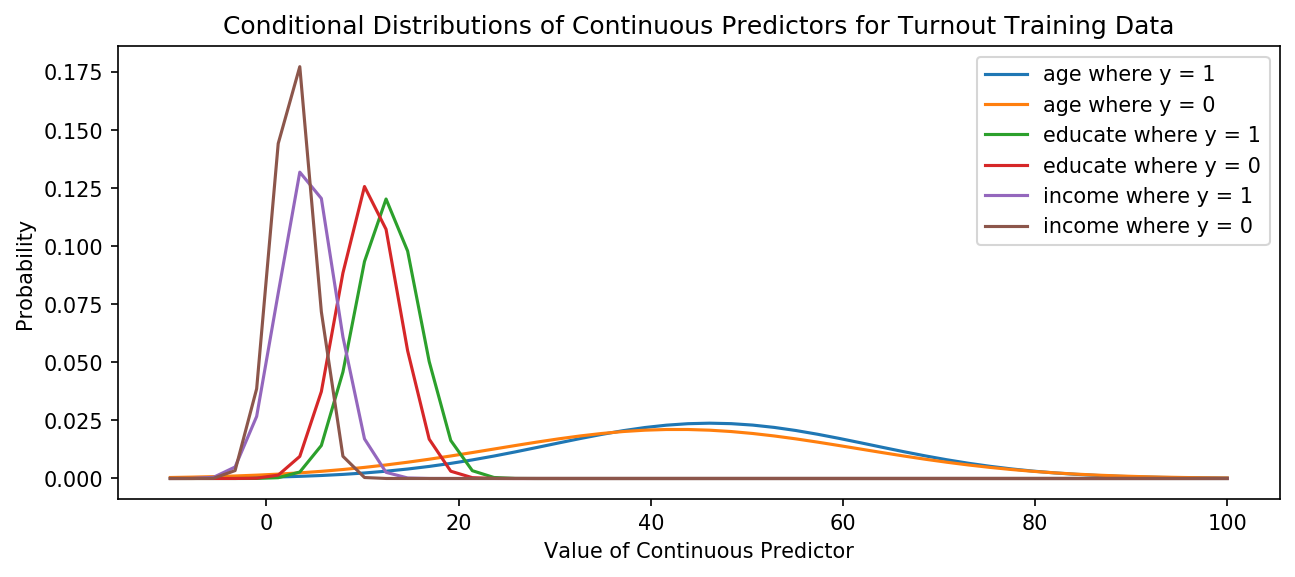

In [9]:
# Plot conditional distributions
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,100)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")
    ax.set_title("Conditional Distributions of Continuous Predictors for Turnout Training Data")
    ax.set(xlabel="Value of Continuous Predictor",ylabel="Probability")

### Generate Predictions

#### Training Data

In [10]:
# Initialize list of predictions
store_preds = []

# Predict outputs for training dataset
for i,row in train.iterrows():
    # Set class probabilities as starting point
    pr_0 = class_probs[0]
    pr_1 = class_probs[1]  
    
    for j in row.index:
        if (j == "id") or (j == "vote"):
            continue
        
        if j == "white":
            # Compute conditional probability for binary predictor
            pr_0 *= cond_probs[(j,row[j],0)]
            pr_1 *= cond_probs[(j,row[j],1)]
        
        else:
            # Compute conditional probabilities for continuous predictor
            pr_0 *= st.norm(dist_locs[(j,0)]['mean'],dist_locs[(j,0)]['sd']).pdf(row[j]) 
            pr_1 *= st.norm(dist_locs[(j,0)]['mean'],dist_locs[(j,0)]['sd']).pdf(row[j]) 
            
    # Assign the class designation to the highest probability
    if pr_0 >= pr_1:
        class_pred = 0
    else:
        class_pred = 1
    
    # Store probability of each outcome and predicted outcome
    store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])

# Print predictions
train_pred = pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])
train_pred

,pr_0,pr_1,pred
0,0.000054,0.000172,1
1,0.000001,0.000003,1
2,0.000004,0.000012,1
3,0.000002,0.000008,1
4,0.000040,0.000127,1
...,...,...,...
1595,0.000056,0.000182,1
1596,0.000017,0.000054,1
1597,0.000044,0.000140,1
1598,0.000081,0.000260,1


In [11]:
# Preliminarily calculate predictive accuracy
accuracy_train = sum(train.vote == train_pred.pred)/train.shape[0]
accuracy_train

0.744375

#### Test Data

In [12]:
# Initialize list of predictions
store_preds = []

# Predict outputs for training dataset
for i,row in test.iterrows():
    # Set class probabilities as starting point
    pr_0 = class_probs[0]
    pr_1 = class_probs[1]  
    
    for j in row.index:
        if (j == "id") or (j == "vote"):
            continue
        
        if j == "white":
            # Compute conditional probability for binary predictor
            pr_0 *= cond_probs[(j,row[j],0)]
            pr_1 *= cond_probs[(j,row[j],1)]
        
        else:
            # Compute conditional probabilities for continuous predictor
            pr_0 *= st.norm(dist_locs[(j,0)]['mean'],dist_locs[(j,0)]['sd']).pdf(row[j]) 
            pr_1 *= st.norm(dist_locs[(j,0)]['mean'],dist_locs[(j,0)]['sd']).pdf(row[j]) 
            
    # Assign the class designation to the highest probability
    if pr_0 >= pr_1:
        class_pred = 0
    else:
        class_pred = 1
    
    # Store probability of each outcome and predicted outcome
    store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])

# Print predictions
test_pred = pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])
test_pred

,pr_0,pr_1,pred
0,0.000004,0.000008,1
1,0.000020,0.000063,1
2,0.000030,0.000098,1
3,0.000079,0.000255,1
4,0.000001,0.000004,1
...,...,...,...
395,0.000015,0.000049,1
396,0.000083,0.000266,1
397,0.000001,0.000004,1
398,0.000054,0.000173,1


In [13]:
# Calculate predictive accuracy
accuracy_test = sum(test.vote == test_pred.pred)/test.shape[0]
accuracy_test

0.7

### Calculate Predictive Accuracy using `sklearn.metrics`

In [14]:
# Prepare data to be fed into sklearn.metrics
train_y = train['vote']
train_x = train[['age','educate','income','white']]
test_y = test['vote']
test_x = test[['age','educate','income','white']]

In [15]:
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

# Create moniker for model class
gnb = GaussianNB()

# Use training data to fit values
gnb.fit(train_x, train_y)

# Predict 
y_pred = gnb.predict(test_x)

# Calculate predictive accuracy of the test data
m.accuracy_score(test_y,y_pred)

0.71

#### Area under the Receiver Operating Characteristic (ROC) curve

In [16]:
# Calculate predictive accuracy of test data
m.roc_auc_score(test_y,y_pred)

0.5714285714285714

In [17]:
# Compute probabilities of each outcome for each observation
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.417308,0.582692
1,0.084880,0.915120
2,0.279069,0.720931
3,0.268680,0.731320
4,0.025347,0.974653
...,...,...
395,0.158396,0.841604
396,0.288806,0.711194
397,0.014993,0.985007
398,0.453210,0.546790


In [18]:
# Generate the False Positive Rate and True Positive Rate using different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

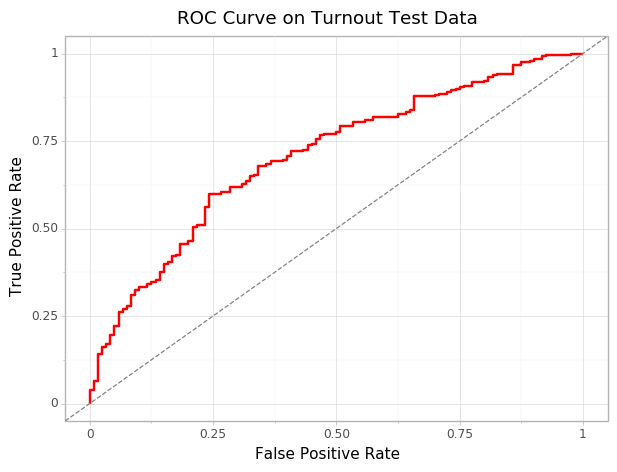

<ggplot: (-9223371871290934304)>

In [19]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="red",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed",color="gray") +
    theme_light() +
    labs(title="ROC Curve on Turnout Test Data",x="False Positive Rate",y="True Positive Rate") +
    theme(figure_size=(7,5))
)

### Analysis of Results

As computed previously, our model's accuracy score on test data is 0.7 while the area under the ROC curve (AUC) is 0.57. While the accuracy score indicates the percentage of the test data that we predicted correctly, the AUC shows the probability that our model will be able to correctly distinguish between voters and non-voters. By this measure, our model appears slightly better than a coin flip.

The above ROC curve illustrates the trade-off that our model makes between correctly identifying voters and incorrectly tagging non-voters as voters. Our model consistently registers True Positive Rates greater than False Positive Rates. This affirms that the model performs better than chance, i.e. a coin flip. Using a coin flip for prediction yields an ROC curve hovering around the 45 degree reference line (as shown in the Annex).

***

## ANNEX
#### Coin Flip

In [20]:
# Initialize list of predictions
store_preds = []

# Predict outputs for training dataset
for i,row in test.iterrows():
    # Generate random number
    pr_0 = np.random.uniform(0,1)
    pr_1 = 1 - pr_0
            
    # Assign the class designation to the highest probability
    if pr_0 >= pr_1:
        class_pred = 0
    else:
        class_pred = 1
    
    # Store probability of each outcome and predicted outcome
    store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])

# Print predictions
coin_pred = pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])
coin_pred

,pr_0,pr_1,pred
0,0.918185,0.081815,0
1,0.078086,0.921914,1
2,0.852417,0.147583,0
3,0.673779,0.326221,0
4,0.055319,0.944681,1
...,...,...,...
395,0.024511,0.975489,1
396,0.094765,0.905235,1
397,0.650948,0.349052,0
398,0.163448,0.836552,1


In [21]:
# Preliminarily calculate predictive accuracy
accuracy_coin = sum(test.vote == coin_pred.pred)/test.shape[0]
accuracy_coin

0.51

### Calculate Predictive Accuracy using `sklearn.metrics`

In [22]:
# Prepare data to be fed into sklearn.metrics
train_y = train['vote']
train_x = train[['age','educate','income','white']]
test_y = test['vote']
test_x = test[['age','educate','income','white']]

#### Accuracy classification score

In [23]:
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

# Create moniker for model class
gnb = GaussianNB()

# Use training data to fit values
gnb.fit(train_x, train_y)

# Predict 
y_pred = gnb.predict(test_x)

# Calculate predictive accuracy of the test data
m.accuracy_score(test_y,coin_pred["pred"])

0.51

#### Area under the Receiver Operating Characteristic (ROC) curve

In [24]:
# Calculate predictive accuracy of test data
m.roc_auc_score(test_y,coin_pred["pred"])

0.5166666666666667

In [25]:
# Generate the False Positive Rate and True Positive Rate using different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, coin_pred["pr_1"])

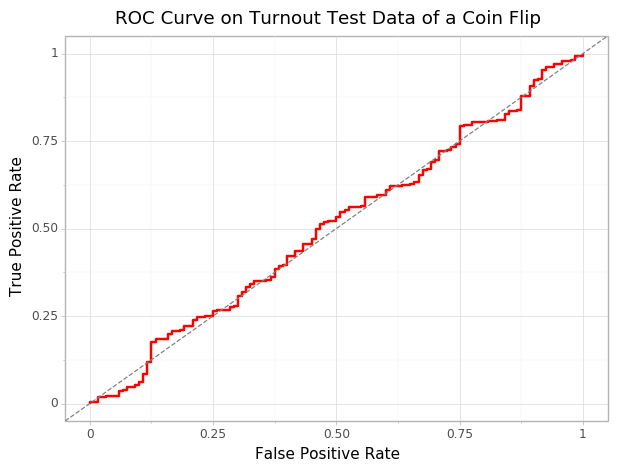

<ggplot: (-9223371871291110876)>

In [28]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="red",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed",color="gray") +
    theme_light() +
    labs(title="ROC Curve on Turnout Test Data of a Coin Flip",x="False Positive Rate",y="True Positive Rate") +
    theme(figure_size=(7,5))
)